In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import h5py
import logging
import numpy as np
import py21cmfast as p21c
import math
from py21cmfast import (
    AstroParams,
    CosmoParams,
    FlagOptions,
    UserParams,
    determine_halo_list,
    initial_conditions,
    perturb_field,
    plotting
    )

/opt/anaconda3/envs/21cmfast/lib/python3.9/site-packages/py21cmfast/_cfg.py:49: UserWarning: Your configuration file is out of date. Updating...
  warnings.warn(
/opt/anaconda3/envs/21cmfast/lib/python3.9/site-packages/py21cmfast/_cfg.py:33: UserWarning: Your configuration file is out of date. Updating...
  warnings.warn("Your configuration file is out of date. Updating...")


Load in the recovered binarized boxes from Jonathan. Also included are the wedge-filtered coeval boxes, the original coeval boxes from `21cmFAST` (which can be compared to our own generation of these boxes using identical initial conditions to ensure our analysis is correct), and the set of redshifts at which the boxes are generated. 

In [49]:
def load_data_from_h5(filename):

    with h5py.File(filename, "r") as hf:

        print("Datasets: ", list(hf.keys()))

        X = hf["X"][:]
        Y = hf["Ytrue"][:]
        Ypred = hf["Ypred"][:]
        redshifts = hf["redshifts"][:]
        #print(Ypred[0].shape)
        #new_Ypred = [Ypred[i].T for i in range(len(redshifts))]

    return X, Y, Ypred, redshifts

results_file = 'z8-9_HII-DIM-128_BOX-LEN-256_coeval_boxes_results.h5'

################ ADD A TRANSPOSE IN HERE SOMEWHERE ##################

'''

X: The wedge-filtered coeval boxes
Y: The original coeval boxes, generated by 21cm Fast, BRIGHTNESS TEMPERATURE
Y_pred: The lightcones that the machine learning model predicts.
redshifts: The redshifts that the coeval boxes were generated at

'''

X, Y, Ypred, redshifts = load_data_from_h5(results_file)

print("X shape: ", X.shape)

Datasets:  ['X', 'Ypred', 'Ytrue', 'redshifts']
X shape:  (2, 128, 128, 128)


In [3]:
np.mean(Ypred[0])
print(redshifts)

[8.   8.25 8.5 ]


In [4]:
print(p21c.AstroParams._defaults_)

{'HII_EFF_FACTOR': 30.0, 'F_STAR10': -1.3, 'F_STAR7_MINI': -2.0, 'ALPHA_STAR': 0.5, 'ALPHA_STAR_MINI': 0.5, 'F_ESC10': -1.0, 'F_ESC7_MINI': -2.0, 'ALPHA_ESC': -0.5, 'M_TURN': 8.7, 'R_BUBBLE_MAX': None, 'ION_Tvir_MIN': 4.69897, 'L_X': 40.0, 'L_X_MINI': 40.0, 'NU_X_THRESH': 500.0, 'X_RAY_SPEC_INDEX': 1.0, 'X_RAY_Tvir_MIN': None, 'F_H2_SHIELD': 0.0, 't_STAR': 0.5, 'N_RSD_STEPS': 20, 'A_LW': 2.0, 'BETA_LW': 0.6, 'A_VCB': 1.0, 'BETA_VCB': 1.8}


Now initialize an identical coeval box using `21cmFAST` with the same initial conditions, which will carry all the additional information on halo positions and sizes which we can use to analyze the recovered boxes.

In [4]:
# Init cond for .h5 file

HII_DIM = 128
BOX_LEN = 128

init_cond = p21c.initial_conditions(
    user_params = {"HII_DIM": HII_DIM, "BOX_LEN": BOX_LEN}, 
    cosmo_params = p21c.CosmoParams(SIGMA_8 = 0.8), 
    random_seed = 42242)
    
redshift = 8.25

pt_box = perturb_field(
    redshift=redshift,
    init_boxes=init_cond,
    #user_params=user_params,
    #cosmo_params=cosmo_params,
    )

halos = determine_halo_list(
    redshift=redshift,
    init_boxes=init_cond,
    #user_params=user_params, 
    #cosmo_params=cosmo_params,
    #astro_params=astro_params,
    #flag_options=flag_options,
    regenerate=True,
    write=False,
    OPTIMIZE=False,
    )

list_halo_coords = halos.halo_coords

/opt/anaconda3/envs/21cmfast/lib/python3.9/site-packages/py21cmfast/inputs.py:485: UserWarning: The USE_INTERPOLATION_TABLES setting has changed in v3.1.2 to be default True. You can likely ignore this warning, but if you relied onhaving USE_INTERPOLATION_TABLES=False by *default*, please set it explicitly. To silence this warning, set it explicitly to True. Thiswarning will be removed in v4.
  warnings.warn(


Ionize the coeval box and plot its brightness temperature as a check (we have already perturbed the box to redshift 8). Plotting a slice of the box requires one to specify an axis and index at which the slice is made, in this instance we have chosen the axis to be $x$ (0), and the index to be 0. The boxes are constructed in such a way that the $x$-dimension is the depth of the box along the line of sight and the $z$ axis is the height of the box (therefore $y$ is just the transverse width of the box). 

/opt/anaconda3/envs/21cmfast/lib/python3.9/site-packages/py21cmfast/plotting.py:101: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  plt.imshow(slc, origin="lower", cmap=cmap, norm=norm, **imshow_kw)


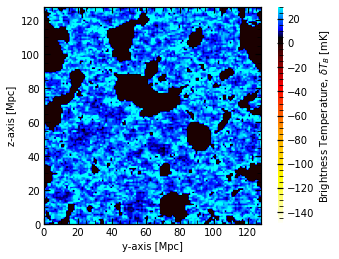

In [5]:
ionized=p21c.ionize_box(perturbed_field = pt_box)
brightness_temp=p21c.brightness_temperature(ionized_box=ionized, perturbed_field=pt_box)
p21c.plotting.coeval_sliceplot(brightness_temp, slice_axis=0, slice_index=0);

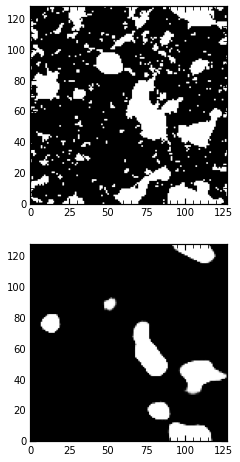

In [42]:
ionized_box8_25 = ionized.xH_box
fig, ax = plt.subplots(2,figsize=[14,8])
ax[0].imshow(ionized_box8_25[0,:,:],cmap='Greys', origin='lower')
ax[1].imshow(Ypred[0].T[0,:,:], cmap='Greys', origin='lower')

Now we can examine what types of halo masses `21cmFAST` generates. This is done using the list of halo-type objects `halos`, which we have already obtained above. These objects contain attributes pertaining to the halo mass and coordinates in the box. Looking at the distribution of halo masses (via a histogram) is useful to understand the range and frequency of halo masses in the box.

In [15]:
# Define function to plot log of halo masses

def plot_histogram(halomasses, name, save=False, ax=None, fig=None, label='', colour='red', bins=None,lims=None):
    if (ax is None) and (fig is None):
        fig,ax = plt.subplots(figsize=(14,8))
        colour='blue'
    log_halomasses = np.log10(halomasses)
    if bins == None:
        bins=len(np.unique(log_halomasses))
    ax.hist(log_halomasses,bins=bins,density=True, lw=1, ec='black', fc=colour, alpha=0.5, label=label,range=lims) # normalize histogram
    ax.set_yscale('log')
    ax.set_xlabel('$log(M_{halo} / M_{Sun})$', fontsize = 20)
    ax.set_title('Halo Mass Distribution Over '+name, fontsize = 20)
    ax.set_ylabel('log(Probability Density)', fontsize = 20);
    ax.tick_params(axis='x',labelsize=20)
    ax.tick_params(axis='y',labelsize=20)
    ax.legend(fontsize=16)
    if save:
        splitname = name.split()
        savename = "_".join(splitname)
        fig1.savefig('halo_mass_distr_'+savename)
    return fig, ax

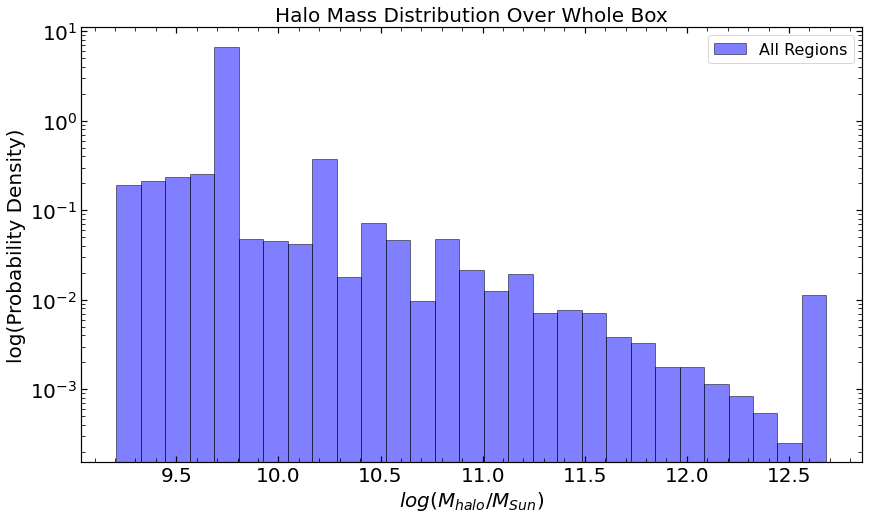

In [16]:
# Plot histogram of halo masses from whole cube

halo_masses_cube = halos.halo_masses
hist_fig, hist_ax = plot_histogram(halo_masses_cube,'Whole Box',save=False,label='All Regions')

To access the halos in a particular slice, we can specify the particular index we want to keep. As mentioned above, the coordinates of the box take the form $(z,y,x)$. This is done below for an $x$-axis slice with index $x=0$. The corresponding halo mass histogram is displayed below as well, and has a similar general shape to that which includes the halo masses from the whole box.

No handles with labels found to put in legend.


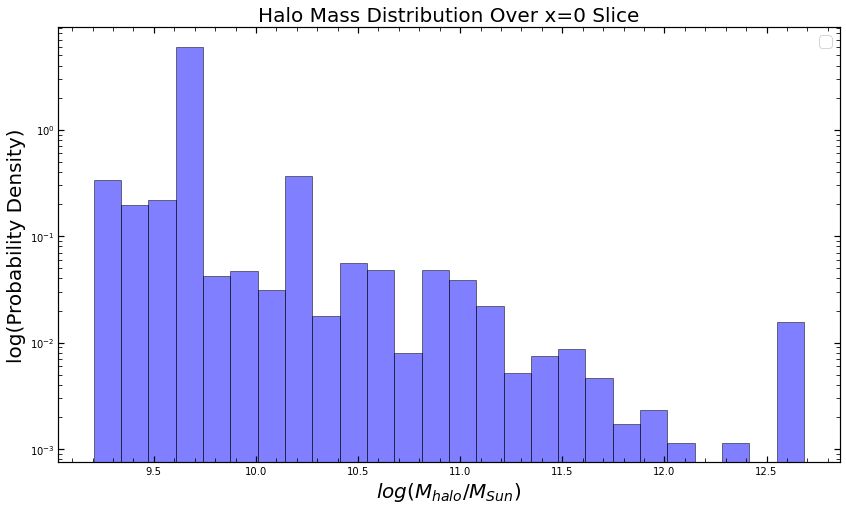

In [9]:
halo_masses_slice = halos.halo_masses[halos.halo_coords[:,2]==0]

hist_slice_fig, hist_slice_ax = plot_histogram(halo_masses_slice, 'x=0 Slice', save=False)

If we wish to get a sorted list of halo masses and halo coordinates (in the same order), this can be done using the following function.

In [10]:
def sort_masses(halomasses, halocoords):
    sorted_halomasses_inds = np.argsort(halomasses)
    sorted_halomasses = halomasses[sorted_halomasses_inds]
    sorted_halocoords = halocoords[sorted_halomasses_inds]
    return [sorted_halomasses,sorted_halocoords]

Given we want to examine what halo masses are found in the recovered boxes, we need to write a function to find the halo coordinates and masses corresponding to those halos found in the ionized bubbles (and neutral areas as well).

In [23]:
def get_n_i_mass_coords(halocoords, halomasses, ionizedbox, n_frac_threshold=0.9):
    '''
    halocoords: 
            Coordinates of halos in box.
    halomasses:
            Masses of halos in box
    ionizedbox: 
            3-D box of HII_DIM sidelength, with entries indicating neutral fraction of voxel. 
    n_frac_threshold:
            Neutral fraction threshold, default is 0.9.
    ''' 
    halo_low_res_coords = halocoords // 3 # need to scale down dimension from high to low resolution
    
    neutral_halo_coords = []
    neutral_halo_masses = []
    ionized_halo_coords = []
    ionized_halo_masses = []
    
    for i in range(len(halo_low_res_coords)): 
        z = halo_low_res_coords[i][0]
        y = halo_low_res_coords[i][1]
        x = halo_low_res_coords[i][2]
        
        if ionizedbox[z,y,x] >=n_frac_threshold: # check if neutral fraction greater than threshold
            neutral_halo_coords.append(np.array([z,y,x]))
            neutral_halo_masses += [halomasses[i]]
            
        else:
            ionized_halo_coords.append(np.array([z,y,x]))
            ionized_halo_masses += [halomasses[i]]

    
    #return [neutral_halo_coords, neutral_halo_masses, ionized_halo_coords, ionized_halo_masses]
    return np.array(neutral_halo_coords),np.array(neutral_halo_masses), np.array(ionized_halo_coords), np.array(ionized_halo_masses)

We can now use this function to find the halo masses in the ionized and neutral regions of the recovered binarized box from Sam's code. At the same time, we can apply the same function to the ground truth map to see what halo (masses) are in those bubbles as well.

In [24]:
# List of sorted (in ascending mass) halo masses and corresponding indices, sort the halo_coords using use

halo_masses_cube = halos.halo_masses
halo_coords_cube = halos.halo_coords

# obtain recovered box and binarize it for plotting simplicity

# recovered box
cutoff = 0.9
binarized_pred = Ypred[1].T # redshift = 8.25
sup_threshold_inds = (binarized_pred >= cutoff) # map to 1
sub_threshold_inds = (binarized_pred < cutoff) # map to 0
binarized_pred[sup_threshold_inds] = 1 
binarized_pred[sub_threshold_inds] = 0
rec_ionized_box = binarized_pred 
n_rec_halo_coords, n_rec_halo_masses, i_rec_halo_coords, i_rec_halo_masses = get_n_i_mass_coords(halo_coords_cube, halo_masses_cube, rec_ionized_box)    

# ground truth box
gt_ionized_box = ionized.xH_box
n_gt_halo_coords, n_gt_halo_masses, i_gt_halo_coords, i_gt_halo_masses = get_n_i_mass_coords(halo_coords_cube, halo_masses_cube, gt_ionized_box)                                                                                                                                                                                                                                  

In [35]:
#Binarize the predicted boxes

def binarize_boxes(boxes, cutoff=0.9):
    num_box = boxes.shape[0]
    for i in range(num_box):
        sup_threshold_inds = (boxes[i] >= cutoff) # map to 1
        sub_threshold_inds = (boxes[i] < cutoff) # map to 0
        boxes[i][sup_threshold_inds] = 1 
        boxes[i][sub_threshold_inds] = 0
    return boxes

gt_ionized_box = binarize_boxes(gt_ionized_box)

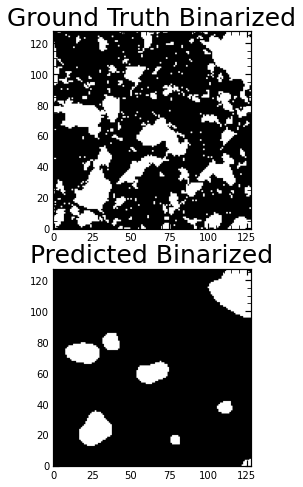

In [37]:
fig,ax=plt.subplots(2,figsize=[14,8])
ax[0].imshow(gt_ionized_box[20,:,:],cmap='Greys', origin='lower')
ax[0].set_title('Ground Truth Binarized', fontsize=25)
ax[1].imshow(rec_ionized_box[20,:,:], cmap='Greys', origin='lower')
ax[1].set_title('Predicted Binarized', fontsize=25)
fig.savefig('nov5_check.png')

Plot the histograms of halo masses in the predicted ionized and neutral regions.

No handles with labels found to put in legend.
No handles with labels found to put in legend.


(<Figure size 1008x576 with 1 Axes>,
 <AxesSubplot:title={'center':'Halo Mass Distribution Over Predicted Ionized Regions n = 999456'}, xlabel='$log(M_{halo} / M_{Sun})$', ylabel='log(Probability Density)'>)

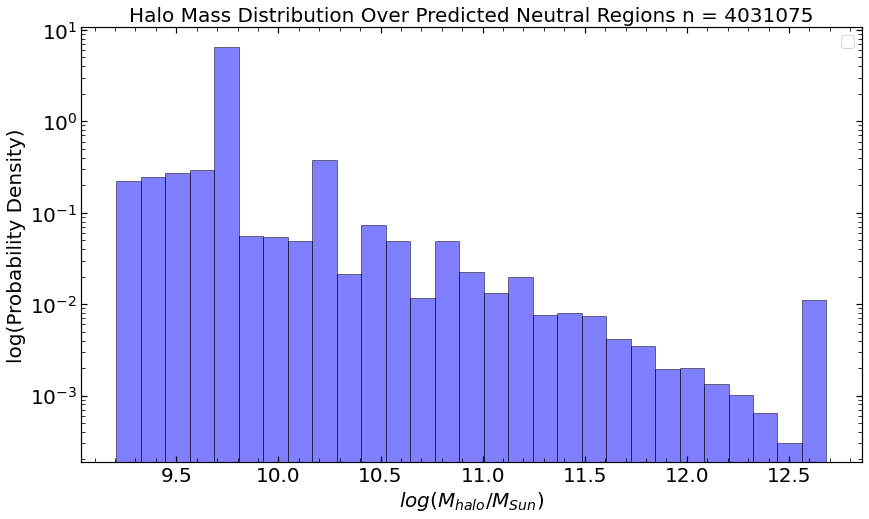

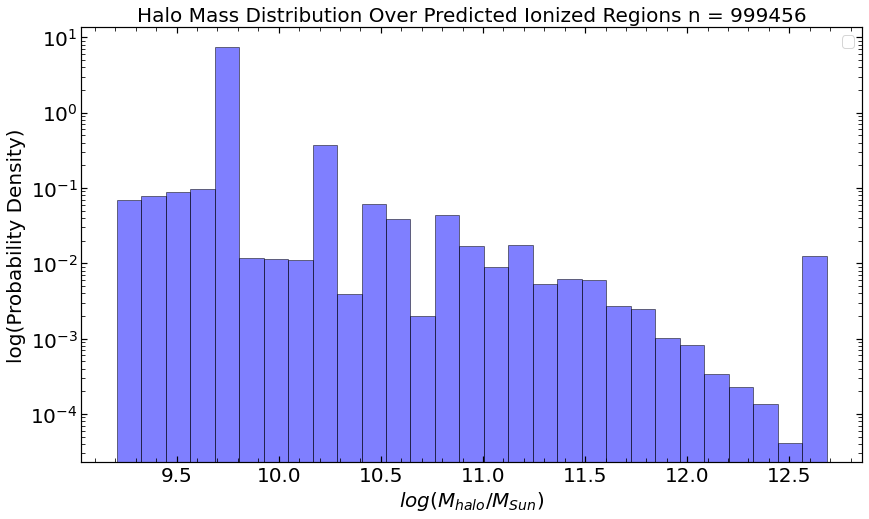

In [83]:
plot_histogram(n_rec_halo_masses,'Predicted Neutral Regions n = '+str(len(n_rec_halo_masses)), save=False)
plot_histogram(i_rec_halo_masses,'Predicted Ionized Regions n = '+str(len(i_rec_halo_masses)), save=False)

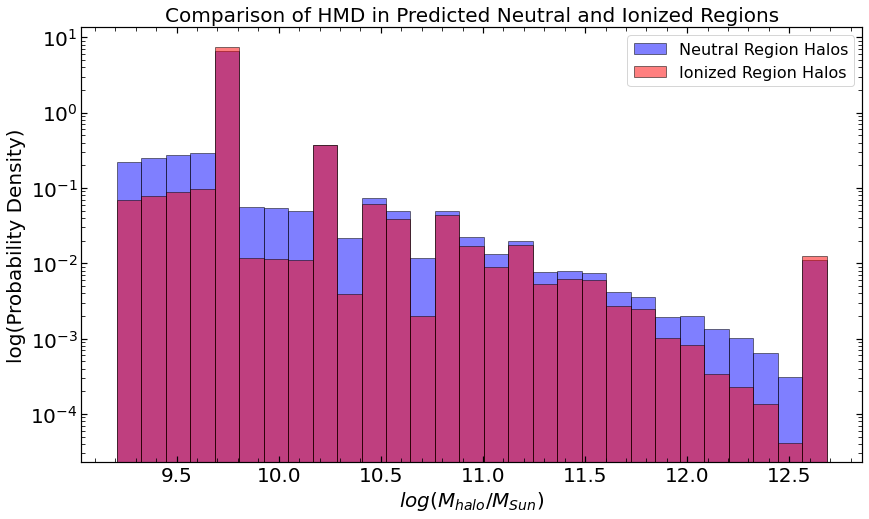

In [73]:
fig1,ax1 = plot_histogram(n_rec_halo_masses,
            'Predicted Neutral Regions n = '+str(len(n_rec_halo_masses)), save=False, label='Neutral Region Halos')
fig2, ax2 = plot_histogram(i_rec_halo_masses,'Comparison of Neutral and Ionized Regions', 
                           save=False, ax=ax1, fig=fig1, label='Ionized Region Halos')
ax2.set_title('Comparison of HMD in Predicted Neutral and Ionized Regions', fontsize=20);

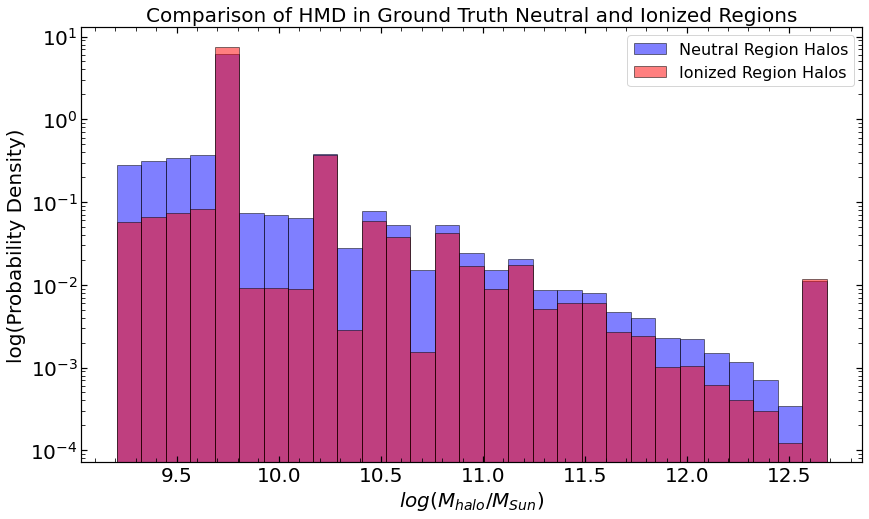

In [74]:
fig3,ax3 = plot_histogram(n_gt_halo_masses,
            'Predicted Neutral Regions n = '+str(len(n_gt_halo_masses)), save=False, label='Neutral Region Halos')
fig4, ax4 = plot_histogram(i_gt_halo_masses,'Comparison of Neutral and Ionized Regions', 
                           save=False, ax=ax3, fig=fig3, label='Ionized Region Halos')
ax4.set_title('Comparison of HMD in Ground Truth Neutral and Ionized Regions', fontsize=20);

Clearly, there are significant differences between the HMDs in the recovered maps vs the ground truth maps ionized and neutral regions. The most obvious difference is that the neutral and ionized region halos mass populations in the predicted maps are relatively identical (with minor differences - they nearly completely overlap), however, the halo mass populations in the neutral and ionized regions of the ground truth maps are quite different - there are roughly fewer halos at all masses in the ionized regions than in the neutral regions, except for the second grouping from the left.

To further investigate we can analyze the population of halo masses that are in the ionized regions of the ground truth maps but not in the ionized regions of the recovered maps.

This does not tell us very much however, given each histogram is independently normalized, so you cannot say directly that one has more of these than the other.


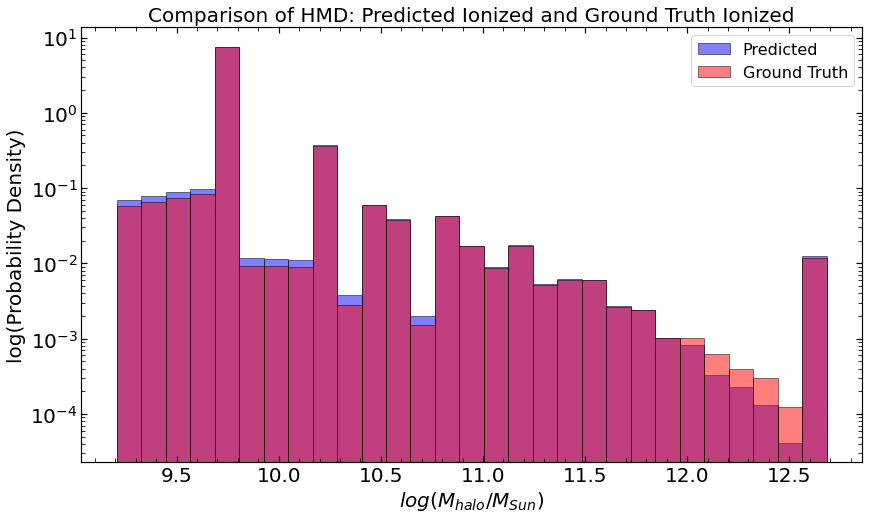

In [75]:
fig5,ax5 = plot_histogram(i_rec_halo_masses,
            'Predicted Neutral Regions n = '+str(len(n_gt_halo_masses)), save=False, label='Predicted')
fig6, ax6 = plot_histogram(i_gt_halo_masses,'Comparison of Neutral and Ionized Regions', 
                           save=False, ax=ax5, fig=fig5, label='Ground Truth')
ax6.set_title('Comparison of HMD: Predicted Ionized and Ground Truth Ionized', fontsize=20);
print('This does not tell us very much however, given each histogram is independently normalized, so you cannot say directly that one has more of these than the other.')

Look at the halo masses in the recovered ionized regions and the ground truth ionized regions, which as we know only take on a discrete set of mass values, so we can just subtract their counts to obtain the difference. We want to know what halo masses are not captured by the predicted ionized bubbles.

All halo masses in ground truth ionized regions are also in predicted ionized regions:  True
[  5725   6640   7434   8297 918294    813    847    824  44323    226
   7177   4511    130   5066   2018   1047   2038    592    706    714
    323    284    127    151    110     70     57     25   1362]
[ 9.206355   9.330533   9.454711   9.578889   9.703067   9.827246
  9.951424  10.075602  10.1997795 10.323957  10.448135  10.572314
 10.696492  10.82067   10.944848  11.069026  11.193204  11.317383
 11.441561  11.565739  11.689917  11.814095  11.938272  12.062451
 12.186629  12.310807  12.434985  12.559163  12.683341 ]
Redshift: 8.25 with GT ionized fraction:  0.6957822
Num missed ionized masses:  1019931
Num incorrectly included ionized masses:  0 



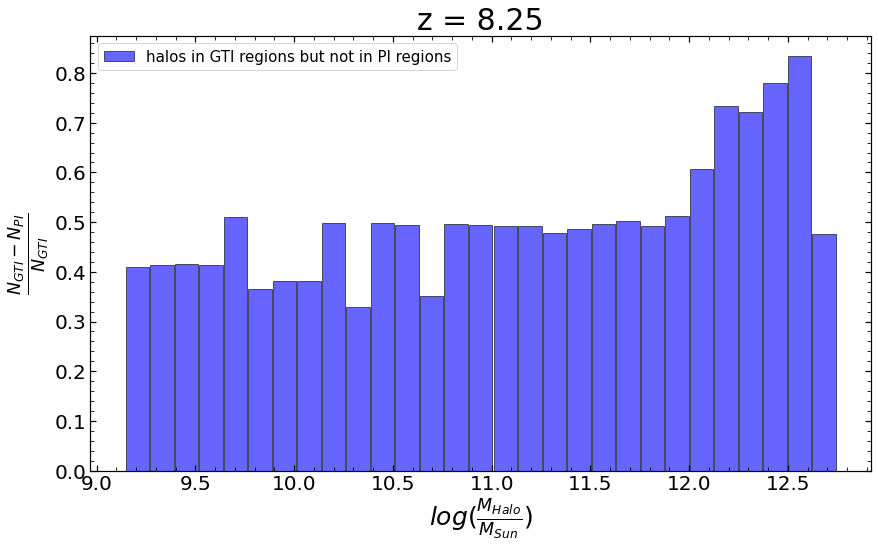

In [40]:
uniq_i_gt_masses, uniq_i_gt_mass_counts = np.unique(i_gt_halo_masses, return_counts=True)
uniq_i_rec_masses, uniq_i_rec_mass_counts = np.unique(i_rec_halo_masses, return_counts=True)

# double check all masses in one are in the other
common_masses = np.intersect1d(uniq_i_gt_masses,uniq_i_rec_masses)
print('All halo masses in ground truth ionized regions are also in predicted ionized regions: ',
      ((len(common_masses)==len(uniq_i_rec_masses)) and (len(common_masses)==len(uniq_i_gt_masses)))) 

common_mass_counts =  uniq_i_gt_mass_counts - uniq_i_rec_mass_counts
print(common_mass_counts)
print(np.log10(common_masses))
plot=True
if plot:
        #start=time.time()
        fig,ax=plt.subplots(figsize=[14,8])

        fracs = common_mass_counts / uniq_i_gt_mass_counts
        i_rec_missed_inds_frac = np.argwhere(fracs > 0)[:,0]
        i_rec_incorr_inds_frac = np.argwhere(fracs < 0)[:,0]
        i_rec_missed_fracs = np.array(fracs[i_rec_missed_inds_frac])
        i_rec_missed_masses = np.array(common_masses[i_rec_missed_inds_frac])
        i_rec_incorr_fracs = np.array(fracs[i_rec_incorr_inds_frac])
        i_rec_incorr_masses = np.array(common_masses[i_rec_incorr_inds_frac])
        print('Redshift: 8.25 with GT ionized fraction: ', np.mean(gt_ionized_box))
        print('Num missed ionized masses: ', np.sum(common_mass_counts[i_rec_missed_inds_frac]))
        print('Num incorrectly included ionized masses: ', np.sum(common_mass_counts[i_rec_incorr_inds_frac]), '\n')
        ax.bar(np.log10(i_rec_missed_masses), i_rec_missed_fracs, width=0.119,alpha=0.6,
                edgecolor='black', linewidth=1,color='blue', label='halos in GTI regions but not in PI regions')
        #ax.bar(np.log10(i_rec_incorr_masses), i_rec_incorr_fracs, width=0.119,alpha=0.6,
        #        edgecolor='black', linewidth=1, color='red', label='halos in PI regions but not in GTI regions')
        ax.set_ylabel(r'$\frac{N_{GTI} - N_{PI}}{N_{GTI}}$', fontsize=25)
        ax.set_xlabel(r'$log(\frac{M_{Halo}}{M_{Sun}})$', fontsize=25)
        ax.tick_params(axis='x',labelsize=20)
        ax.tick_params(axis='y',labelsize=20)
        ax.set_title('z = 8.25', fontsize=30)
        ax.legend(fontsize=15)
        fig.savefig('/users/jacobkennedy/Desktop/PHYS_459/Github/PHYS459/102521/bar_graph_mischaracterized_halos_z8.25'.jpeg');
        #end=time.time()
    #print('Plotting took: ', end-start)

In [80]:
# Look at halos incorrectly identified as ionized by the predicted map, and those missed by predicted map that
# are ionized in the ground truth map

i_rec_missed_inds = np.argwhere(common_mass_counts > 0)[:,0]
i_rec_incorr_inds = np.argwhere(common_mass_counts < 0)[:,0]
i_rec_missed_counts = np.array(common_mass_counts[i_rec_missed_inds])
i_rec_missed_masses = np.array(common_masses[i_rec_missed_inds])
i_rec_incorr_counts = -1*np.array(common_mass_counts[i_rec_incorr_inds])
i_rec_incorr_masses = np.array(common_masses[i_rec_incorr_inds])

# make array to call plt.hist on
n_halos = np.sum(i_rec_missed_counts)
i_rec_missed_halo_masses = np.zeros(n_halos)
start_ind = 0
for i in range(len(i_rec_missed_counts)):
    end_ind = start_ind+i_rec_missed_counts[i]
    i_rec_missed_halo_masses[start_ind:end_ind] = i_rec_missed_masses[i]
    start_ind=end_ind

n_halos2 = np.sum(i_rec_incorr_counts)
i_rec_incorr_halo_masses = np.zeros(n_halos2)
start_ind2 = 0
for j in range(len(i_rec_incorr_counts)):
    end_ind2 = start_ind2+i_rec_incorr_counts[j]
    i_rec_incorr_halo_masses[start_ind2:end_ind2] = i_rec_incorr_masses[j]
    start_ind2=end_ind2

In [26]:
print(common_masses)

[1.6082555e+09 2.1405882e+09 2.8491228e+09 3.7921825e+09 5.0473948e+09
 6.7180820e+09 8.9417677e+09 1.1901493e+10 1.5840890e+10 2.1084226e+10
 2.8063105e+10 3.7351997e+10 4.9715511e+10 6.6171359e+10 8.8074084e+10
 1.1722663e+11 1.5602865e+11 2.0767413e+11 2.7641430e+11 3.6790750e+11
 4.8968499e+11 6.5177079e+11 8.6750691e+11 1.1546519e+12 1.5368417e+12
 2.0455364e+12 2.7226092e+12 3.6237929e+12 4.8232682e+12]


No handles with labels found to put in legend.
/opt/anaconda3/envs/21cmfast/lib/python3.9/site-packages/numpy/lib/histograms.py:905: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges
No handles with labels found to put in legend.


(9.206355094909668, 12.683341026306152)

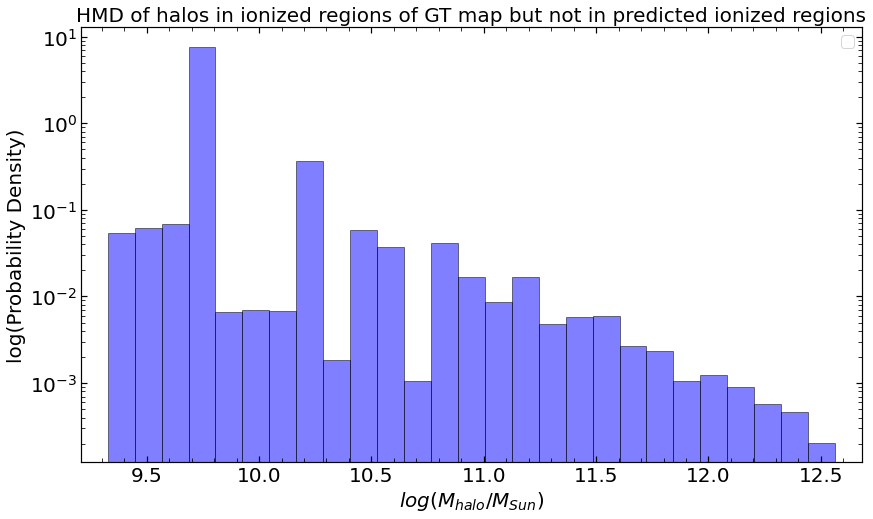

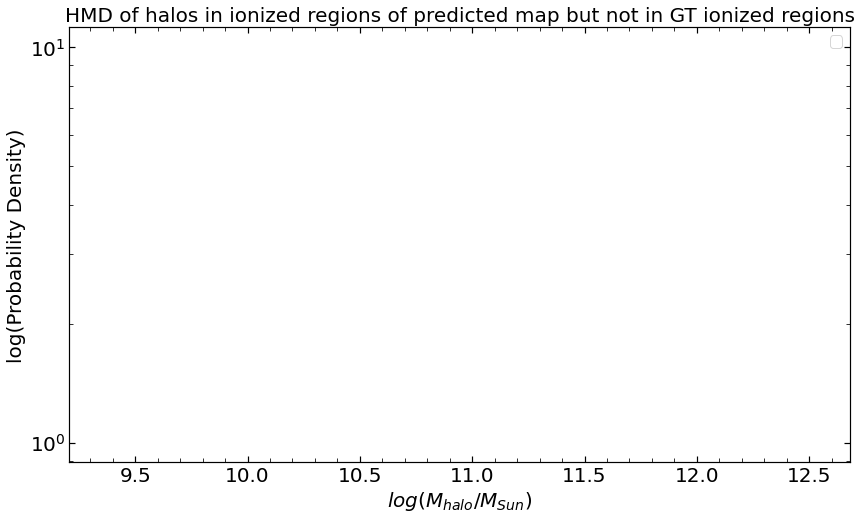

In [81]:
num_bins = len(common_masses)
xmin,xmax = np.log10(common_masses)[0],np.log10(common_masses)[-1] 

fig7,ax7 = plot_histogram(i_rec_missed_halo_masses, '', save=False, bins=num_bins, lims=(xmin,xmax))
ax7.set_title('HMD of halos in ionized regions of GT map but not in predicted ionized regions', fontsize=20)
ax7.set_xlim(xmin=xmin, xmax=xmax)
#fig7.savefig('halos_ionized_in_GT_not_in_pred_ionizedz8.25.jpeg')

fig8,ax8 = plot_histogram(i_rec_incorr_halo_masses, '', save=False, bins=num_bins, lims=(xmin,xmax)) 
ax8.set_title('HMD of halos in ionized regions of predicted map but not in GT ionized regions', fontsize=20)
ax8.set_xlim(xmin=xmin, xmax=xmax)
#fig8.savefig('halos_ionized_in_pred_not_in_GT_ionizedz8.25.jpeg');

In [299]:
if 1:
    
    # now find unique masses
    uniq_i_gt_masses, uniq_i_gt_mass_counts = np.unique(i_gt_halo_masses, return_counts=True)
    uniq_i_rec_masses, uniq_i_rec_mass_counts = np.unique(i_rec_halo_masses, return_counts=True)

    # double check all masses in one are in the other
    common_masses = np.intersect1d(uniq_i_gt_masses,uniq_i_rec_masses)
    print('All halo masses in ground truth ionized regions are also in predicted ionized regions: ',
      ((len(common_masses)==len(uniq_i_rec_masses)) and (len(common_masses)==len(uniq_i_gt_masses)))) 

    common_mass_counts =  uniq_i_gt_mass_counts - uniq_i_rec_mass_counts
    
    if plot:
        start=time.time()
        fig,ax=plt.subplots(figsize=[14,8])

        fracs = common_mass_counts / uniq_i_gt_mass_counts
        i_rec_missed_inds_frac = np.argwhere(fracs > 0)[:,0]
        i_rec_incorr_inds_frac = np.argwhere(fracs < 0)[:,0]
        i_rec_missed_fracs = np.array(fracs[i_rec_missed_inds_frac])
        i_rec_missed_masses = np.array(common_masses[i_rec_missed_inds_frac])
        i_rec_incorr_fracs = np.array(fracs[i_rec_incorr_inds_frac])
        i_rec_incorr_masses = np.array(common_masses[i_rec_incorr_inds_frac])
        print('Redshift: ', repr(redshifts[i]), ', with GT ionized fraction: ', np.mean(gt_ionized_box))
        print('Num missed ionized masses: ', np.sum(common_mass_counts[i_rec_missed_inds_frac]))
        print('Num incorrectly included ionized masses: ', np.sum(common_mass_counts[i_rec_incorr_inds_frac]), '\n')
        ax.bar(np.log10(i_rec_missed_masses), i_rec_missed_fracs, width=0.119,alpha=0.6,
                edgecolor='black', linewidth=1,color='blue', label='halos in GTI regions but not in PI regions')
        ax.bar(np.log10(i_rec_incorr_masses), i_rec_incorr_fracs, width=0.119,alpha=0.6,
                edgecolor='black', linewidth=1, color='red', label='halos in PI regions but not in GTI regions')
        ax.set_ylabel(r'$\frac{N_{GTI} - N_{PI}}{N_{GTI}}$', fontsize=25)
        ax.set_xlabel(r'$log(\frac{M_{Halo}}{M_{Sun}})$', fontsize=25)
        ax.tick_params(axis='x',labelsize=20)
        ax.tick_params(axis='y',labelsize=20)
        ax.legend(fontsize=15)
        #fig.savefig('/users/jacobkennedy/Desktop/PHYS_459/Github/PHYS459/102521/bar_graph_mischaracterized_halos_z'+repr(redshifts[i])+'.jpeg');
        end=time.time()
    #print('Plotting took: ', end-start)

1202194 17209


In [287]:
print(len(uniq_i_gt_masses[:-1]), len(uniq_i_gt_mass_counts))

29 30


In [278]:
i_rec_incorr_halo_masses

array([1.67565427e+09, 1.67565427e+09, 1.67565427e+09, ...,
       9.17650719e+10, 9.17650719e+10, 9.17650719e+10])

In [279]:
i_rec_missed_halo_masses

array([5.25892198e+09, 5.25892198e+09, 5.25892198e+09, ...,
       6.68880444e+12, 6.68880444e+12, 6.68880444e+12])

In [30]:
p21c.AstroParams._defaults_ # default astrophysical parameters

{'HII_EFF_FACTOR': 30.0,
 'F_STAR10': -1.3,
 'F_STAR7_MINI': -2.0,
 'ALPHA_STAR': 0.5,
 'ALPHA_STAR_MINI': 0.5,
 'F_ESC10': -1.0,
 'F_ESC7_MINI': -2.0,
 'ALPHA_ESC': -0.5,
 'M_TURN': 8.7,
 'R_BUBBLE_MAX': None,
 'ION_Tvir_MIN': 4.69897,
 'L_X': 40.0,
 'L_X_MINI': 40.0,
 'NU_X_THRESH': 500.0,
 'X_RAY_SPEC_INDEX': 1.0,
 'X_RAY_Tvir_MIN': None,
 'F_H2_SHIELD': 0.0,
 't_STAR': 0.5,
 'N_RSD_STEPS': 20,
 'A_LW': 2.0,
 'BETA_LW': 0.6,
 'A_VCB': 1.0,
 'BETA_VCB': 1.8}

One interesting thing to note is the degeneracy of halo masses, which we can quantify by looking at the number of unique halo masses produced in the simulation as follows. As we see, the majority of the halos seem to be of one mass (nearly 3.85 million of the total 4.8 million halos). The unique halo masses also happen to be equally spaced in log-space.

No handles with labels found to put in legend.


Unique halo masses (log base 10):  [ 9.224184   9.348363   9.472541   9.596719   9.720897   9.845075
  9.969253  10.0934305 10.217609  10.341787  10.465965  10.590143
 10.714321  10.838499  10.962677  11.086856  11.211034  11.335212
 11.45939   11.583568  11.707746  11.8319235 11.956102  12.08028
 12.204458  12.328636  12.452814  12.576992  12.70117   12.825349 ] 
 Unique halo masses counts:  [ 113718  126531  139084  148070 3842290   27366   25867   23946  209813
   10183   38567   28938   28532   12014    2949    7671   11169    5761
    2484    4444    1927    2093    1259     956     787     543     317
     226     134    4927]


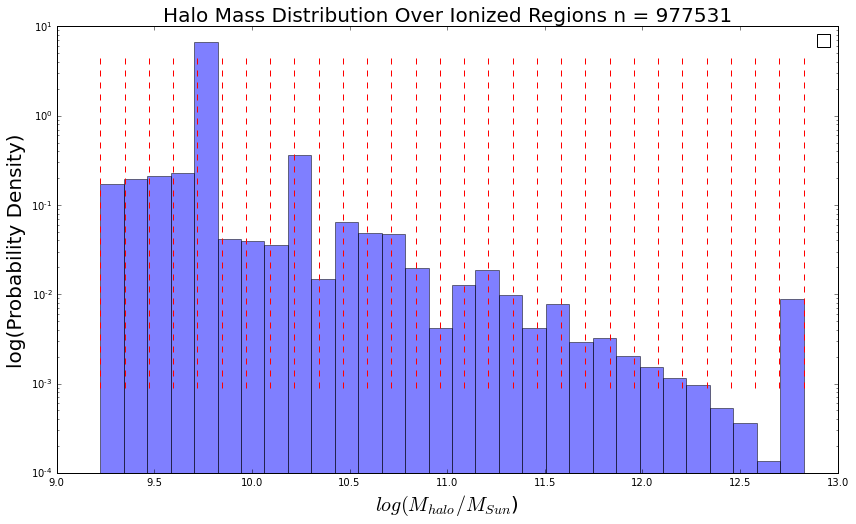

In [226]:
unique_loghalo_masses, unique_loghalo_mass_counts = np.unique(np.log10(halo_masses_cube), return_counts=True)
print('Unique halo masses (log base 10): ', unique_loghalo_masses, '\n', 
      'Unique halo masses counts: ',unique_loghalo_mass_counts)
fig2, ax2 = plot_histogram(i_box_halo_masses,'Ionized Regions n = '+str(len(i_box_halo_masses)))
ax2.vlines(unique_loghalo_masses, ymin=0.9*1e-3, ymax=5, linestyles='--', color='r');

We can check that our halo sorting algorithm is working properly by overplotting the designated neutral and ionized halo coordinates onto a recovered binarized slice of the coeval box. Here, we will again choose the $x=0$ slice.

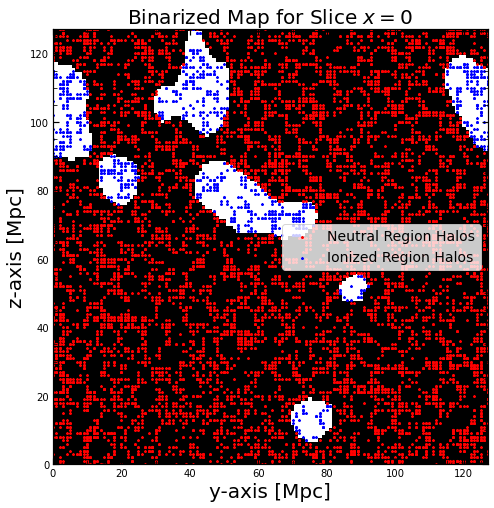

In [93]:
# We need to get the halo coords with x = 0

ionized_slice = ionized_box[:,:,0]
halo_coords_slice = halos.halo_coords[halos.halo_coords[:,2]==0]
halo_masses_slice = halos.halo_masses[halos.halo_coords[:,2]==0]
nslice_halo_coords, nslice_halo_masses, islice_halo_coords, islice_halo_masses = get_n_i_mass_coords(halo_coords_slice, halo_masses_slice, ionized_slice)                                                                                                                                                                                                                                  

fig3, ax3 = plt.subplots(figsize=[14, 8])

ax3.imshow(ionized_slice, cmap='Greys')
plt.gca().invert_yaxis()
im = ax3.scatter(x=nslice_halo_coords[:,1], y=nslice_halo_coords[:,0], 
            marker='*', s=5.0, label = 'Neutral Region Halos', c='r')
im2 = ax3.scatter(x=islice_halo_coords[:,1], y=islice_halo_coords[:,0], 
            marker='*', s=5.0, label = 'Ionized Region Halos', c='blue')
ax3.set_xlim(0, 127)
ax3.set_ylim(0, 127)
ax3.legend(fontsize=14, loc='right')
ax3.set_ylabel('z-axis [Mpc]', fontsize=20)
ax3.set_xlabel('y-axis [Mpc]', fontsize=20)
ax3.set_title('Binarized Map for Slice $x = 0$', fontsize=20);
#fig3.savefig('/Users/jacobkennedy/Desktop/PHYS_459/'+'overtop_neutral_5_slices_deep'+'.jpeg')

Clearly, the sorting algorithm is working correctly, as the ionized region halos appear in the white bubbles, and the neutral halos in the black space.

[ 3.09191361e+09 -9.76242145e+00]


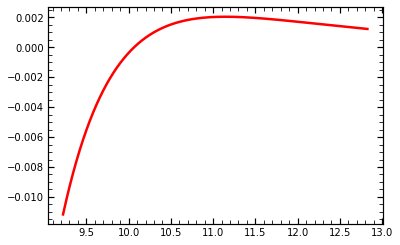

In [235]:
# power law fit to histogram
from scipy.optimize import curve_fit

def power_law(x, A, alpha):
    return A*x**alpha

log_halo_masses = np.log10(i_halo_masses_box)
data_entries, bins = np.histogram(log_halo_masses, bins=10, density=True)

binscenters = np.array([0.5 * (bins[i] + bins[i+1]) for i in range(len(bins)-1)])
popt, pcov = curve_fit(power_law, xdata=binscenters, ydata=data_entries)# p0=[2, -0.001])
print(popt)
xspace = np.linspace(min(log_halo_masses),max(log_halo_masses), 1000)

# Plot the histogram and the fitted function.
plt.bar(binscenters, data_entries, width=bins[1] - bins[0], color='navy', label=r'Histogram entries')
plt.plot(xspace, power_law(xspace, *popt), color='darkorange', linewidth=2.5, label=r'Fitted function')
plt.plot(xspace,  power_law(xspace, *popt)-power_law(xspace, 3.97032615e+09, -9.87071191), color='red', linewidth=2.5, label=r'Fitted function')

In [202]:
# Now look at all halos in a rectangular prism 5 voxels deep, sum up mass in this prism

n_slice_halo_inds = np.argwhere(n_halo_coords_box[:,2] < 5)
i_slice_halo_inds = np.argwhere(i_halo_coords_box[:,2] < 5)
n_slice_halo_masses = n_halo_masses_box[n_slice_halo_inds][:,0]
i_slice_halo_masses = i_halo_masses_box[i_slice_halo_inds][:,0]
n_slice_halo_coords = n_halo_coords_box[n_slice_halo_inds][:,0]
i_slice_halo_coords = i_halo_coords_box[i_slice_halo_inds][:,0]

In [203]:
# get total mass in a voxel prism 5 slices deep

n_masses_grid = np.zeros((128,128))
for i in range(len(n_slice_halo_coords)):
    n_z_coord, n_y_coord = n_slice_halo_coords[i][1], n_slice_halo_coords[i][0]
    n_masses_grid[n_z_coord, n_y_coord] += n_slice_halo_masses[i]
i_masses_grid = np.zeros((128,128))
for i in range(len(i_slice_halo_coords)):
    i_z_coord, i_y_coord = i_slice_halo_coords[i][1], i_slice_halo_coords[i][0]
    i_masses_grid[i_z_coord, i_y_coord] += i_slice_halo_masses[i]

/var/folders/xs/9jq8mv4s1clbtpmn6f0vrgsc0000gp/T/ipykernel_1534/3630856351.py:6: RuntimeWarning: divide by zero encountered in log10
  im = ax.imshow(np.log10(n_masses_grid.T), cmap='coolwarm')


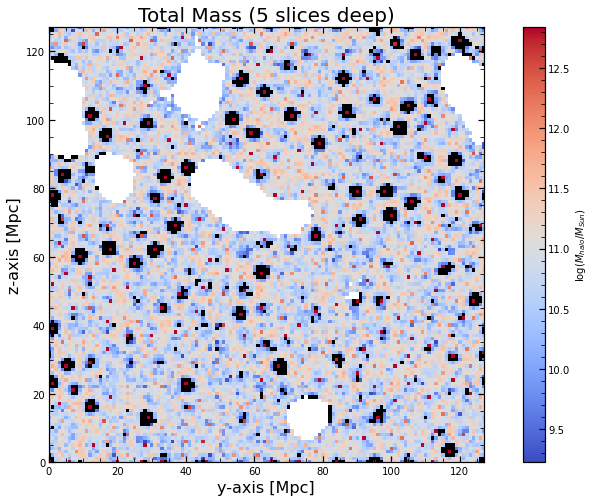

In [206]:
fig, ax = plt.subplots(figsize=[14, 8])


slice_binarized_pred = binarized_pred[:,:,0]
ax.imshow(slice_binarized_pred, cmap='Greys')
im = ax.imshow(np.log10(n_masses_grid.T), cmap='coolwarm')
#ax.imshow(i_masses_grid, cmap='jet') #,  interpolation='nearest')
#plt.gca().invert_yaxis()
#im = ax.scatter(x=n_slice_halo_coords[:,1], y=n_slice_halo_coords[:,0], 
#            marker='*', s=5.0, label = 'Neutral Region Halos', c=np.log10(n_slice_halo_masses), cmap='jet')
#im2 = ax.scatter(x=i_slice_halo_coords[:,1], y=i_slice_halo_coords[:,0], 
#            marker='*', s=5.0, label = 'Ionized Region Halos', c=np.log10(i_slice_halo_masses), cmap='jet')
fig.colorbar(im, label='log($M_{halo}/M_{Sun}$)', ax=ax)
ax.set_xlim(0, 127)
ax.set_ylim(0, 127)
#ax[i].legend(fontsize=12, loc='right')
ax.set_ylabel('z-axis [Mpc]', fontsize=16)
ax.set_xlabel('y-axis [Mpc]', fontsize=16)
ax.set_title('Total Mass (5 slices deep)', fontsize=20)
fig.savefig('/Users/jacobkennedy/Desktop/PHYS_459/'+'overtop_neutral_5_slices_deep'+'.jpeg')

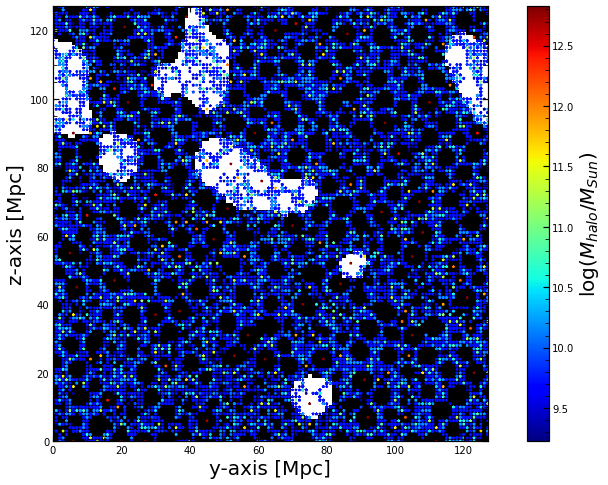

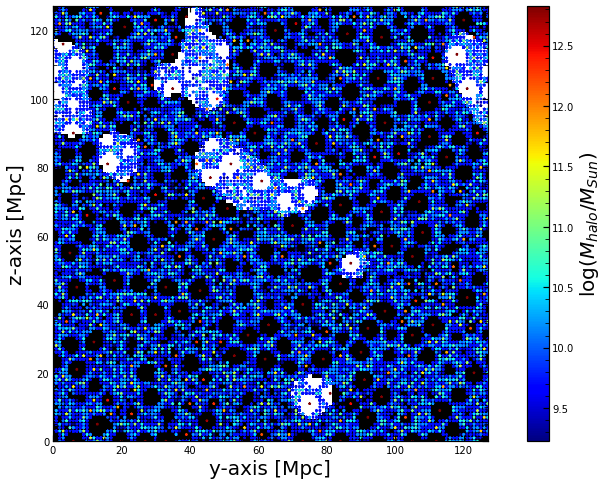

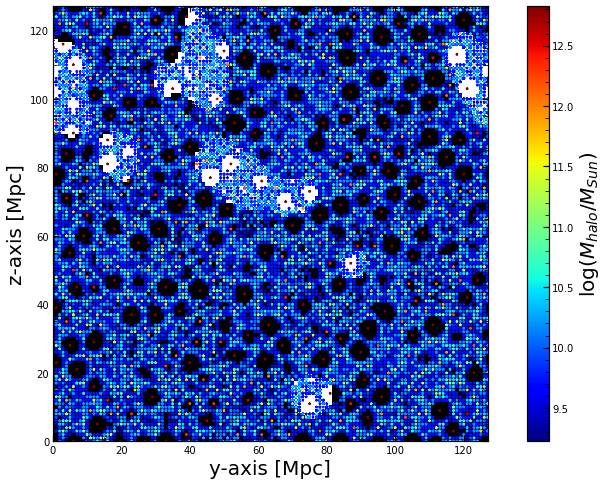

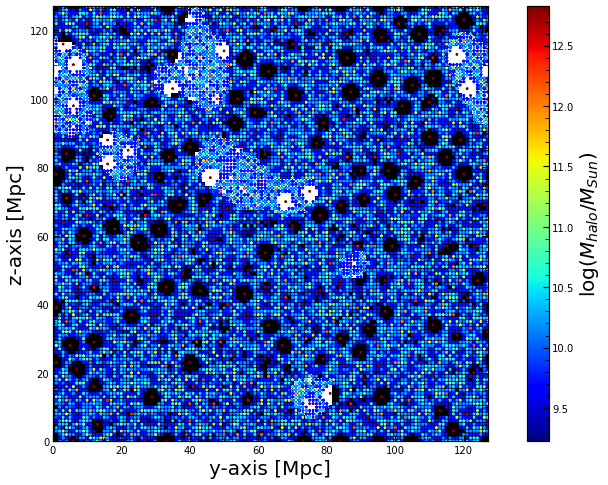

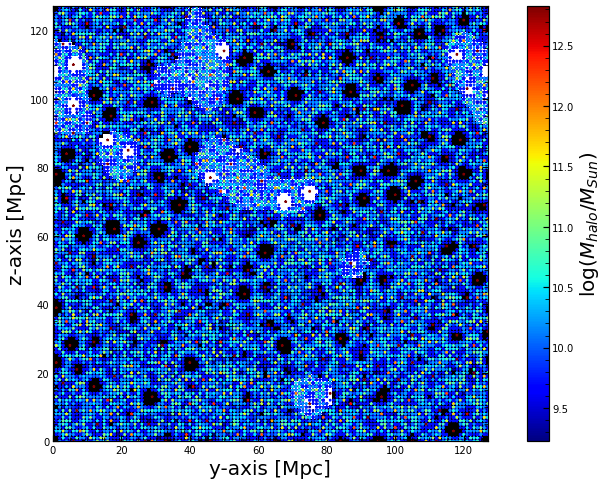

In [37]:
# For a constant background, we plot the first slice of binarized bubbles

if 0:
    num_slice = 10
    fig, ax = plt.subplots(nrows=10, ncols=1, figsize=[30, 80])
if 1:
    num_slice = 5
    #fig, ax = plt.subplots(figsize=[14, 8])

for i in range(num_slice):
    fig, ax = plt.subplots(figsize=[14, 8])
    # Now get the halo masses and coords corresponding to a slice along axis=0, slice_index = 0
    n_halo_coords_box = halo_coords_low_res[neutral_halo_inds]
    i_halo_coords_box = halo_coords_low_res[ionized_halo_inds]
    n_halo_masses_box = sorted_halo_masses[neutral_halo_inds]
    i_halo_masses_box = sorted_halo_masses[ionized_halo_inds]

    n_slice_halo_inds = np.argwhere(n_halo_coords_box[:,2] < i+1).flatten() # will progressively show more
    i_slice_halo_inds = np.argwhere(i_halo_coords_box[:,2] < i+1).flatten()
    n_slice_halo_masses = n_halo_masses_box[n_slice_halo_inds]
    i_slice_halo_masses = i_halo_masses_box[i_slice_halo_inds]
    n_slice_halo_coords = n_halo_coords_box[n_slice_halo_inds]
    i_slice_halo_coords = i_halo_coords_box[i_slice_halo_inds]
    
    #if we just want to see where the large halos are
    
    n_slice_log_halo_masses = np.log10(n_slice_halo_masses)
    i_slice_log_halo_masses = np.log10(i_slice_halo_masses)
    n_slice_large_log_halo_inds = np.argwhere(n_slice_log_halo_masses>=12.0).flatten()
    i_slice_large_log_halo_inds = np.argwhere(i_slice_log_halo_masses>=12.0).flatten()
    n_slice_large_log_halo_masses = n_slice_log_halo_masses[n_slice_large_log_halo_inds]
    i_slice_large_log_halo_masses = i_slice_log_halo_masses[i_slice_large_log_halo_inds]
    n_slice_large_halo_coords = n_slice_halo_coords[n_slice_large_log_halo_inds]
    i_slice_large_halo_coords = i_slice_halo_coords[i_slice_large_log_halo_inds]
    
    # Now plot to make sure the halos have been assigned to the proper region visually

    slice_binarized_pred = binarized_pred[:,:,0] 
    ax.imshow(slice_binarized_pred, cmap='Greys')#,  interpolation='nearest')
    plt.gca().invert_yaxis()
    im = ax.scatter(x=n_slice_halo_coords[:,1], y=n_slice_halo_coords[:,0], 
               marker='*', s=5.0, label = 'Neutral Region Halos', c=np.log10(n_slice_halo_masses), cmap='jet')
    im2 = ax.scatter(x=i_slice_halo_coords[:,1], y=i_slice_halo_coords[:,0], 
               marker='*', s=5.0, label = 'Ionized Region Halos', c=np.log10(i_slice_halo_masses), cmap='jet')
    fig.colorbar(im, label='log($M_{halo}/M_{Sun}$)', ax=ax).set_label(label='log($M_{halo}/M_{Sun}$)',size=20)

    ax.set_xlim(0, 127)
    ax.set_ylim(0, 127)
    #ax[i].legend(fontsize=12, loc='right')
    ax.set_ylabel('z-axis [Mpc]', fontsize=20)
    ax.set_xlabel('y-axis [Mpc]', fontsize=20)
    filename = 'fixed_foreground_with_numslice_galaxies' + str(i)
    fig.savefig('/Users/jacobkennedy/Desktop/PHYS_459/'+filename+'.jpeg')

In [29]:
np.unique(n_slice_large_log_halo_masses)

array([12.08028 , 12.204458, 12.328636, 12.452814, 12.576992, 12.70117 ,
       12.825349], dtype=float32)

In [36]:
n_uniq_masses, n_uniq_mass_counts = np.unique(n_halo_masses_box, return_counts=True)
i_uniq_masses, i_uniq_mass_counts = np.unique(i_halo_masses_box, return_counts=True)
n_masses_12_counts = np.sum(n_uniq_mass_counts[-1:])
i_masses_12_counts = np.sum(i_uniq_mass_counts[-1:])
n_masses_12_frac = n_masses_12_counts / len(n_halo_masses_box)
i_masses_12_frac = i_masses_12_counts / len(i_halo_masses_box)

print('Percentage of largest halo masses in neutral regions: ' + repr(n_masses_12_frac*100))
print('Percentage of largest halo masses in ionized regions: ' + repr(i_masses_12_frac*100))

Percentage of largest halo masses in neutral regions: 0.10148152097445146
Percentage of largest halo masses in ionized regions: 0.1048560096815344


In [6]:
# Convert halo_coords_slice into distance coords to plot overtop of bubble plot

def vox_to_dist(box_len, HII_dim, vox_coords):
    dim = HII_dim*3
    dist_coords = (box_len/dim)*vox_coords
    return dist_coords

dist_halo_coords_slice = vox_to_dist(BOX_LEN, HII_DIM, halo_coords_slice[:, :2])

# Note: Indexing of the coeval boxes is [z,y,x], and hence a slice-axis=-1 $\implies$ along z (slice of x-y plane), slice-axis=0 $\implies$ along x (slice of z-y plane), slice-axis=+1 $\implies$ along y (slice of z-x plane).

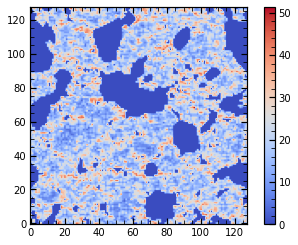

In [9]:
orig_coeval_box = Y[0]
orig_coeval_box_slice = orig_coeval_box[:,:,0]
#fig, ax = plt.subplots(figsize=[14, 8])
plt.imshow(orig_coeval_box_slice, cmap='coolwarm')#,  interpolation='nearest')
plt.gca().invert_yaxis()
#plt.gca().invert_xaxis()
plt.colorbar()
plt.show()

Ionized bubbles are those with zero 21cm signal, so $\Delta T = 0$, hence these areas will appear white in binarized boxes, whilst neutral areas will be black (presence of 21cm signal). Ypred contains the normalized predicted data not yet binarized. Therefore, we will adopt the cutoff used in Gagnon-Hartman et al. 2021 of 0.9, to classify a box as ionized or neutral. Therefore, any voxel with a value $\geq 0.9$ will be mapped to 1.0, and hence be considered neutral. Conversely, any voxel $<0.9$ will be mapped to 0, and hence be classified as fully ionized.

In [14]:
# Plot the binarized data after applying 0.9 cutoff, do so for tranverse slice at z=0

cutoff = 0.9
y_0 = Ypred[0]
slice_binarized_pred = y_0[:,:,0] # z = 0
super_threshold_indices = (slice_binarized_pred >= cutoff) # map to 1
sub_threshold_indices = (slice_binarized_pred < cutoff) # map to 0
slice_binarized_pred[super_threshold_indices] = 1 # 
slice_binarized_pred[sub_threshold_indices] = 0

NameError: name 'dist_halo_coords_slice' is not defined

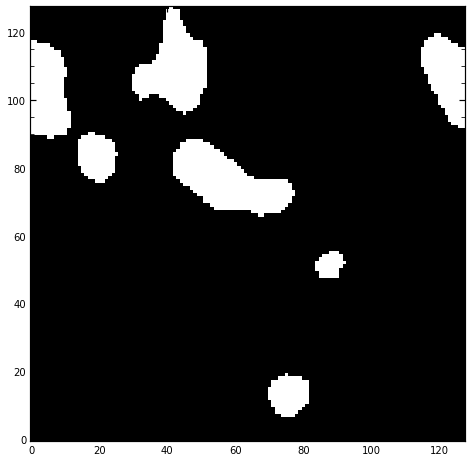

In [63]:
fig, ax = plt.subplots(figsize=[14, 8])
ax.imshow(slice_binarized_pred, cmap='Greys')#,  interpolation='nearest')
# for x=x_coord, y=y_coord, c=mass, and cmap will put gradient of masses
plt.gca().invert_yaxis()
im = ax.scatter(x=dist_halo_coords_slice[:,0], y=dist_halo_coords_slice[:,1], 
           marker='*', s=5.0, c=np.log10(halo_masses_slice), cmap='jet')
fig.colorbar(im, label='log($M_{halo}/M_{Sun}$)', ax=ax)
ax.set_xlim(0, 127.6666666)
ax.set_ylim(0, 127.6666666)
ax.set_ylabel('z-axis [Mpc]', fontsize=16)
ax.set_xlabel('y-axis [Mpc]', fontsize=16)
#plt.show()
#fig.savefig('/Users/jacobkennedy/Desktop/PHYS_459/color_coded_masses_over_bubbles.jpeg')

In [60]:
i_halo_coords_box[:,1]//3

array([ 69, 111, 105, ...,  39,  39,   9], dtype=int32)

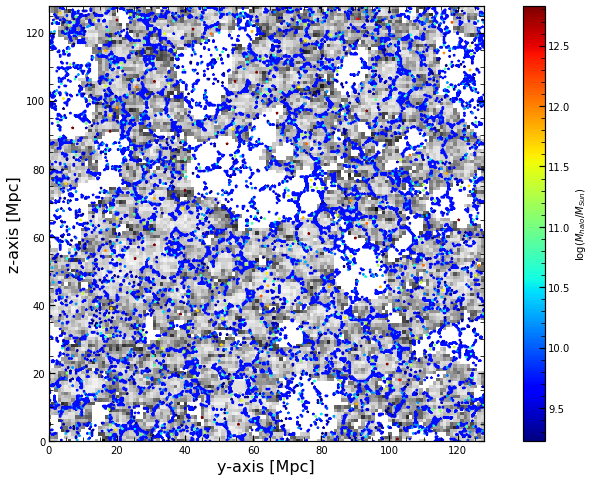

In [18]:


fig, ax = plt.subplots(figsize=[14, 8])
ax.imshow(orig_coeval_box_slice, cmap='Greys')#,  interpolation='nearest')
# for x=x_coord, y=y_coord, c=mass, and cmap will put gradient of masses
plt.gca().invert_yaxis()
im = ax.scatter(x=dist_halo_coords_slice[:,0], y=dist_halo_coords_slice[:,1], 
           marker='*', s=5.0, c=np.log10(halo_masses_slice), cmap='jet')
fig.colorbar(im, label='log($M_{halo}/M_{Sun}$)', ax=ax)
ax.set_xlim(0, 127.6666666)
ax.set_ylim(0, 127.6666666)
ax.set_ylabel('z-axis [Mpc]', fontsize=16)
ax.set_xlabel('y-axis [Mpc]', fontsize=16)
fig.savefig('/Users/jacobkennedy/Desktop/PHYS_459/color_coded_masses_over_bubbles2.jpeg')

In [102]:
print(slice_binarized_pred)

[[1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 ...
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]]


In [105]:
a = np.array([0.01, 0.9, 0.91, 0.5, 0.001])
super_threshold_indices = (a >= 0.9)
sub_threshold_indices = (a < 0.9)
a[super_threshold_indices] = 1
a[sub_threshold_indices] = 0

In [106]:
print(a)

[0. 1. 1. 0. 0.]
